In [5]:
from pyinform.transferentropy import transfer_entropy
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials
from ephysvibe.trials.spikes import firing_rate
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
from scipy import stats
import seaborn as sns
import warnings
seed=2024

In [29]:
xs = [0,1,1,1,1,0,0,0,0]
ys = [0,0,1,1,1,1,0,0,0]
transfer_entropy(xs, ys, k=1)

0.8112781244591329

In [7]:
def align_all_trials_all_epochs(sp_sample_on,mask,neu_data,code_samples,time_before):
    alig = np.full((sp_sample_on.shape[0],sp_sample_on.shape[1]+1000),np.nan)
    t_s_off = ((code_samples[:,5] - code_samples[:,4] )+time_before).astype(int).tolist()
    t_d_off = ((code_samples[:,6] - code_samples[:,4] )+time_before).astype(int).tolist()
    max_dur_s = np.max(t_s_off)
    max_dur_d = np.max(t_d_off)
    for i in range(len(t_s_off)):
        # sample
        alig[i,:t_s_off[i]] = sp_sample_on[i,:t_s_off[i]]
        # delay
        alig[i,max_dur_s:max_dur_s+(t_d_off[i]-t_s_off[i])] = sp_sample_on[i,t_s_off[i]:t_d_off[i]]
        # test
        alig[i,max_dur_d:max_dur_d+(sp_sample_on.shape[1]-t_d_off[i])] = sp_sample_on[i,t_d_off[i]:]

    x = firing_rate.convolve_signal(arr=alig,fs = 1000,w_size=0.1,w_std=0.015,axis=-1)

    s11_mask = neu_data.sample_id[mask] == 11
    s51_mask = neu_data.sample_id[mask] == 51
    s55_mask = neu_data.sample_id[mask] == 55
    s15_mask = neu_data.sample_id[mask] == 15
    s0_mask  = neu_data.sample_id[mask] == 0

    s11_mean = np.nanmean(x[s11_mask],axis=0)
    s51_mean = np.nanmean(x[s51_mask],axis=0)
    s55_mean = np.nanmean(x[s55_mask],axis=0)
    s15_mean = np.nanmean(x[s15_mask],axis=0)
    s0_mean  = np.nanmean(x[s0_mask ],axis=0)

    x_mean_sub = x.copy()
    x_mean_sub[s11_mask] = x_mean_sub[s11_mask]-s11_mean
    x_mean_sub[s51_mask] = x_mean_sub[s51_mask]-s51_mean
    x_mean_sub[s55_mask] = x_mean_sub[s55_mask]-s55_mean
    x_mean_sub[s15_mask] = x_mean_sub[s15_mask]-s15_mean
    x_mean_sub[s0_mask] = x_mean_sub[s0_mask]-s0_mean 

    x_no_nan = np.full(x_mean_sub.shape,np.nan)
    for i in range(x_mean_sub.shape[0]):
        no_nan = x_mean_sub[i,~np.isnan(x_mean_sub[i])]
        x_no_nan[i,:no_nan.shape[0]] = no_nan

In [6]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'D:/data/'#'C:/Users/camil/Documents/int/'

In [8]:
# Load data
n_test=1
min_trials=10
nonmatch=False
time_before_sample=500
time_before_test = 500
start=-200
start_test=-400
end_test = n_test*450
end_sample=450+400

idx_start_sample = time_before_sample + start 
idx_start_test = time_before_test + start_test 
idx_end_sample = time_before_sample+end_sample
idx_end_test = time_before_test+end_test
trial_dur = end_sample-start+end_test-start_test

In [9]:
area1='lip'
area2='v4'
subject='Riesling'

neu_path1 = basepath+'/session_struct/'+area1+'/neurons/*neu.h5'
all_path_list1 = glob.glob(neu_path1)
all_sessions = []
for ipath in all_path_list1:
    all_sessions.append(ipath.replace("\\", "/").split("/")[-1][:19])
all_sessions = np.unique(all_sessions)

neu_path2 = basepath+'/session_struct/'+area2+'/neurons/*neu.h5'
all_path_list2 = glob.glob(neu_path2)
all_path_list1 = glob.glob(neu_path1)

session = str(all_sessions[6])
session

'2022-12-14_10-50-49'

In [10]:
mask1,mask2 = [],[]
for path in all_path_list1:
    mask1.append(
        session == path.replace("\\", "/").rsplit("/")[-1].rsplit("_" + subject)[0]
    )
for path in all_path_list2:
    mask2.append(
        session == path.replace("\\", "/").rsplit("/")[-1].rsplit("_" + subject)[0]
    )
path_list1 = np.array(all_path_list1)[np.array(mask1)]
path_list2 = np.array(all_path_list2)[np.array(mask2)]

In [ ]:


def get_neurons_fr(path):
    neurons={}
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    # Select trials aligned to sample onset
    sp_sample_on,mask = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before_sample,
        error_type= 0,
    )
    # Select trials aligned to sample onset
    sp_test_on,tmask = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="test_on_1",
        time_before = time_before_test,
        error_type= 0,
    )

    if np.logical_or(np.mean(sp_sample_on[:,idx_start_sample:idx_end_sample])>5/1000,np.mean(sp_test_on[:,idx_start_test:idx_end_test])>5/1000):
        #sp_conv = firing_rate.convolve_signal(arr=sp_sample_on,fs = 1000,w_size=0.1,w_std=0.015,axis=-1)
        sp_sample = sp_sample_on[:,idx_start_sample:idx_end_sample]
        sp_test = sp_test_on[:,idx_start_test:idx_end_test]
        sp=np.concatenate((sp_sample,sp_test),axis=1)
        narea= neu_data.area
        cnumber=str(neu_data.cluster_number)
        cgroup=neu_data.cluster_group

        neurons[narea + '_' +cgroup+cnumber] = {'fr':sp_sample_on,'sp':sp,'path':path,'neu_data':neu_data,'mask':mask}
           
    return neurons

In [12]:
neurons1={}
neurons2={}
for iarea,path_list in zip([area1,area2],[path_list1,path_list2]):
    for i,path in enumerate(path_list):
        neu_data = NeuronData.from_python_hdf5(path)
        select_block=1
        code=1
        # Select trials aligned to sample onset
        sp_sample_on,mask = align_trials.align_on(
            sp_samples=neu_data.sp_samples,
            code_samples=neu_data.code_samples,
            code_numbers=neu_data.code_numbers,
            trial_error=neu_data.trial_error,
            block=neu_data.block,
            pos_code=neu_data.pos_code,
            select_block= select_block,
            select_pos= code,
            event ="sample_on",
            time_before = time_before_sample,
            error_type= 0,
        )
        # Select trials aligned to sample onset
        sp_test_on,tmask = align_trials.align_on(
            sp_samples=neu_data.sp_samples,
            code_samples=neu_data.code_samples,
            code_numbers=neu_data.code_numbers,
            trial_error=neu_data.trial_error,
            block=neu_data.block,
            pos_code=neu_data.pos_code,
            select_block= select_block,
            select_pos= code,
            event ="test_on_1",
            time_before = time_before_test,
            error_type= 0,
        )

        if np.logical_or(np.mean(sp_sample_on[:,idx_start_sample:idx_end_sample])>5/1000,np.mean(sp_test_on[:,idx_start_test:idx_end_test])>5/1000):
            #sp_conv = firing_rate.convolve_signal(arr=sp_sample_on,fs = 1000,w_size=0.1,w_std=0.015,axis=-1)
            sp_sample = sp_sample_on[:,idx_start_sample:idx_end_sample]
            sp_test = sp_test_on[:,idx_start_test:idx_end_test]
            sp_conv=np.concatenate((sp_sample,sp_test),axis=1)
            narea= neu_data.area
            cnumber=str(neu_data.cluster_number)
            cgroup=neu_data.cluster_group
            if iarea==area1:
                neurons1[narea + '_' +cgroup+cnumber] = {'fr':sp_sample_on,'conv':sp_conv,'path':path,'neu_data':neu_data,'mask':mask}
            if iarea==area2:
                neurons2[narea + '_' +cgroup+cnumber] = {'fr':sp_sample_on,'conv':sp_conv,'path':path,'neu_data':neu_data,'mask':mask}

In [18]:
neu_data = neurons1[list(neurons1.keys())[0]]['neu_data']
mask = neurons1[list(neurons1.keys())[0]]['mask']
code_samples=neu_data.code_samples[mask]
code_numbers=neu_data.code_numbers[mask]
s11_mask = neu_data.sample_id[mask] == 11
s51_mask = neu_data.sample_id[mask] == 51
s55_mask = neu_data.sample_id[mask] == 55
s15_mask = neu_data.sample_id[mask] == 15
s0_mask  = neu_data.sample_id[mask] == 0

In [56]:
ineu1=2
ineu2=13
n1 = list(neurons1.keys())[ineu1]
n2 = list(neurons2.keys())[ineu2]

In [57]:
t_neus1=neurons1[n1]['conv'][s11_mask]
t_neus2=neurons2[n2]['conv'][s11_mask]

In [58]:
t_neus1.shape

(98, 1900)

In [59]:
neurons2[n2]['mask']

array([False, False, False, ..., False, False, False])

In [60]:
te=[]
for i in range(1500):
    xs = t_neus1[:,i]
    ys = t_neus2[:,i]
    te.append(transfer_entropy(xs, ys, k=20))

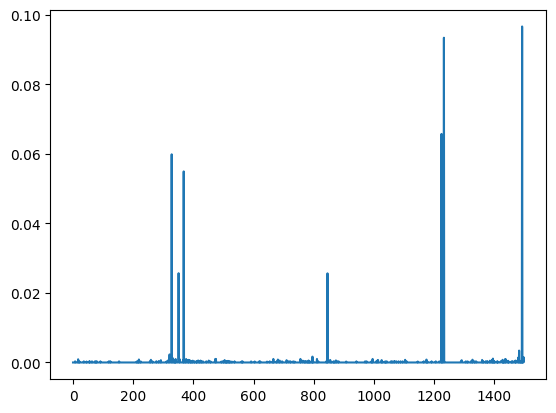

In [61]:
plt.plot(te)

In [62]:
import frites

In [63]:
t_neus1
t_neus2.shape

(98, 1900)

ValueError: x and y can be no greater than 2D, but have shapes (1900,) and (1900, 2, 5)

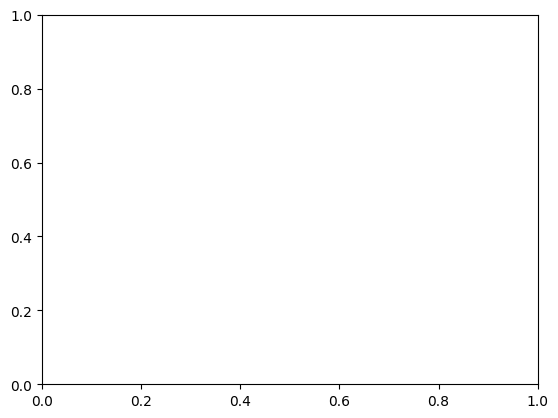

In [64]:
plt.plot(sp_conv[:5].T)

In [65]:
t_neus = np.transpose(np.array((t_neus1,t_neus2)),(1,0,2))
sp_conv = firing_rate.convolve_signal(arr=t_neus,fs = 1000,w_size=0.1,w_std=0.015,axis=-1)

In [73]:
a=frites.conn.conn_te(sp_conv,times=np.arange(1900),roi=np.arange(2),max_delay=30,return_delays=True)

Defining links (n_roi=2; directed=True; net=False, nb_min_links=None)
Compute Transfer Entropy (n_pairs=2, delays=[0:1:30])


  0%|          | Estimating TE : 0/2 [00:00<?,       ?it/s]

In [74]:
a.data.shape

(2, 30, 1870)

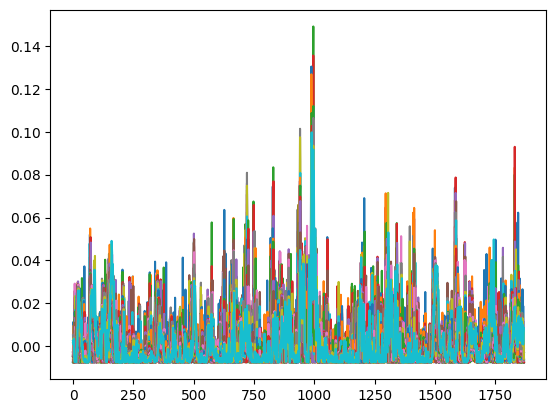

In [77]:
_=plt.plot(a.data[0].T)

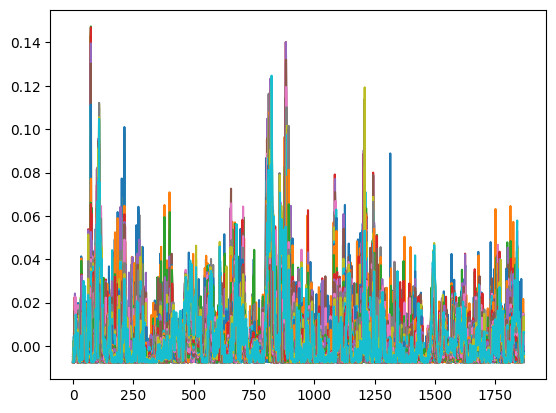

In [78]:
_=plt.plot(a.data[1].T)